In [3]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score

ROOT_DIR = '/gscratch/ubicomp/hughsun/HAM10000/ResNet'

In [2]:
device = 'cuda'
model = torchvision.models.resnet50(pretrained=True).to(device)
model.fc = nn.Linear(2048, 7).to(device)
model.load_state_dict(torch.load(f'{ROOT_DIR}/skin_models/skinmodel50.pt'))

<All keys matched successfully>

# evaluate model as a whole.

In [4]:
valdir = f'{ROOT_DIR}/skin/validation/'

In [5]:
val_transforms = transforms.Compose([
    transforms.Resize((224, 280)),
    torchvision.transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

val_dataset = datasets.ImageFolder(
    valdir, transform=val_transforms)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=64, shuffle=False,
    pin_memory=False, drop_last=False)

In [6]:
num_classes = 7

predlist = torch.zeros(0,dtype=torch.long, device='cpu')
lbllist = torch.zeros(0,dtype=torch.long, device='cpu')
predlistauc = torch.zeros(0,dtype=torch.long, device='cpu')

model.eval()

with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_loader):        
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])
        predlistauc = torch.cat([predlistauc,nn.functional.softmax(outputs, dim=1).cpu()])
predlist = predlist.numpy()
lbllist = lbllist.numpy()
predlistauc = predlistauc.numpy()

In [7]:
conf_mat=confusion_matrix(lbllist, predlist)

In [8]:
target_names = ['MEL','NV','BCC','AKIEC','BKL','DF','VASC',]

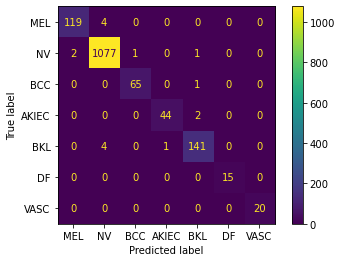

In [10]:
ConfusionMatrixDisplay(conf_mat, display_labels=target_names).plot(values_format="d")

In [11]:
print(classification_report(lbllist, predlist, target_names=target_names))

              precision    recall  f1-score   support

         MEL       0.98      0.97      0.98       123
          NV       0.99      1.00      0.99      1081
         BCC       0.98      0.98      0.98        66
       AKIEC       0.98      0.96      0.97        46
         BKL       0.97      0.97      0.97       146
          DF       1.00      1.00      1.00        15
        VASC       1.00      1.00      1.00        20

    accuracy                           0.99      1497
   macro avg       0.99      0.98      0.98      1497
weighted avg       0.99      0.99      0.99      1497



In [12]:
lbllist_one_hot = nn.functional.one_hot(torch.tensor([lbllist]), num_classes=num_classes)
every_auc = roc_auc_score(lbllist_one_hot.view([predlistauc.shape[0], predlistauc.shape[1]]), 
                                          predlistauc, multi_class='ovr', average=None)
for i, every in enumerate(target_names):
    print(f'AUC of class {every} = {every_auc[i]}')

AUC of class MEL = 0.9993313688595401
AUC of class NV = 0.9995063331672953
AUC of class BCC = 0.9999576477563898
AUC of class AKIEC = 0.9999101069727024
AUC of class BKL = 0.999797207547935
AUC of class DF = 1.0
AUC of class VASC = 1.0


<ipython-input-12-162f7b232c8a>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180544224/work/torch/csrc/utils/tensor_new.cpp:201.)
  lbllist_one_hot = nn.functional.one_hot(torch.tensor([lbllist]), num_classes=num_classes)


              precision    recall  f1-score   support

         MEL       0.98      0.95      0.96       615
          NV       0.99      1.00      0.99      5405
         BCC       0.96      1.00      0.98       330
       AKIEC       0.98      0.96      0.97       230
         BKL       0.99      0.97      0.98       730
          DF       0.95      1.00      0.97        75
        VASC       1.00      1.00      1.00       100

    accuracy                           0.99      7485
   macro avg       0.98      0.98      0.98      7485
weighted avg       0.99      0.99      0.99      7485

AUC of class MEL = 0.9993659246636134
AUC of class NV = 0.999599818544083
AUC of class BCC = 0.9999385892467654
AUC of class AKIEC = 0.9998603661642645
AUC of class BKL = 0.9998541922269653
AUC of class DF = 0.9999784075573549
AUC of class VASC = 1.0


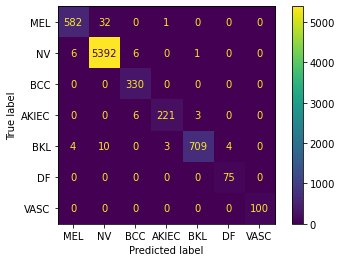

In [13]:
val_transforms = transforms.Compose([
    transforms.Resize((224, 280)),
    torchvision.transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply(transforms=[transforms.RandomRotation(degrees=(-180, 180))], p=0.99),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


val_dataset = datasets.ImageFolder(
    valdir, transform=val_transforms)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=64, shuffle=True,
    pin_memory=False, drop_last=False)

num_classes = 7

predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
predlistauc = torch.zeros(0,dtype=torch.long, device='cpu')
for n in range(5):
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(val_loader):
            model.eval()
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Append batch prediction results
            predlist=torch.cat([predlist,preds.view(-1).cpu()])
            lbllist=torch.cat([lbllist,classes.view(-1).cpu()])
            predlistauc = torch.cat([predlistauc,nn.functional.softmax(outputs, dim=1).cpu()])
predlist = predlist.numpy()
lbllist = lbllist.numpy()
predlistauc = predlistauc.numpy() 

# Confusion matrix, classification report and AUC
conf_mat=confusion_matrix(lbllist, predlist)
target_names = ['MEL','NV','BCC','AKIEC','BKL','DF','VASC',]
ConfusionMatrixDisplay(conf_mat, display_labels=target_names).plot(values_format="d")
print(classification_report(lbllist, predlist, target_names=target_names))
lbllist_one_hot = nn.functional.one_hot(torch.tensor([lbllist]), num_classes=num_classes)
every_auc = roc_auc_score(lbllist_one_hot.view([predlistauc.shape[0], predlistauc.shape[1]]), 
                                          predlistauc, multi_class='ovr', average=None)
for i, every in enumerate(target_names):
    print(f'AUC of class {every} = {every_auc[i]}')

# Evaluate model performance for female and male separately.

In [19]:
import os
from shutil import copyfile
import pandas as pd
import random

ROOT_DIR = '/gscratch/ubicomp/hughsun/HAM10000/ResNet'
split_size = 0.8

In [4]:
metadata = pd.read_csv(f'{ROOT_DIR}/HAM10000_metadata.csv')

<AxesSubplot:>

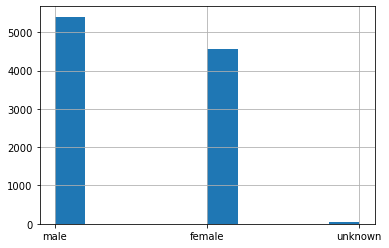

In [9]:
metadata['sex'].hist()

In [21]:
metadata

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


## First need to create two separate validation image folders for female and male.

In [48]:
def createMaleFemaleFolders():
    '''
    create the necessary image folders for female and male validation dataset.
    '''
    os.mkdir(f'{ROOT_DIR}/skin/validation_male_female/')
    
    os.mkdir(f'{ROOT_DIR}/skin/validation_male_female/male/')
    os.mkdir(f'{ROOT_DIR}/skin/validation_male_female/female/')
    
    os.mkdir(f'{ROOT_DIR}/skin/validation_male_female/male/0.MEL/')
    os.mkdir(f'{ROOT_DIR}/skin/validation_male_female/male/1.NV/')
    os.mkdir(f'{ROOT_DIR}/skin/validation_male_female/male/2.BCC/')
    os.mkdir(f'{ROOT_DIR}/skin/validation_male_female/male/3.AKIEC/')
    os.mkdir(f'{ROOT_DIR}/skin/validation_male_female/male/4.BKL/')
    os.mkdir(f'{ROOT_DIR}/skin/validation_male_female/male/5.DF/')
    os.mkdir(f'{ROOT_DIR}/skin/validation_male_female/male/6.VASC/')
    
    os.mkdir(f'{ROOT_DIR}/skin/validation_male_female/female/0.MEL/')
    os.mkdir(f'{ROOT_DIR}/skin/validation_male_female/female/1.NV/')
    os.mkdir(f'{ROOT_DIR}/skin/validation_male_female/female/2.BCC/')
    os.mkdir(f'{ROOT_DIR}/skin/validation_male_female/female/3.AKIEC/')
    os.mkdir(f'{ROOT_DIR}/skin/validation_male_female/female/4.BKL/')
    os.mkdir(f'{ROOT_DIR}/skin/validation_male_female/female/5.DF/')
    os.mkdir(f'{ROOT_DIR}/skin/validation_male_female/female/6.VASC/')

In [23]:
os.listdir(f'{ROOT_DIR}/skin/validation/0.MEL')

['ISIC_0032872.jpg',
 'ISIC_0028026.jpg',
 'ISIC_0026296.jpg',
 'ISIC_0033416.jpg',
 'ISIC_0033362.jpg',
 'ISIC_0031025.jpg',
 'ISIC_0032624.jpg',
 'ISIC_0028227.jpg',
 'ISIC_0031529.jpg',
 'ISIC_0033034.jpg',
 'ISIC_0030110.jpg',
 'ISIC_0033946.jpg',
 'ISIC_0029013.jpg',
 'ISIC_0026604.jpg',
 'ISIC_0026870.jpg',
 'ISIC_0030150.jpg',
 'ISIC_0025832.jpg',
 'ISIC_0026877.jpg',
 'ISIC_0031778.jpg',
 'ISIC_0031670.jpg',
 'ISIC_0028103.jpg',
 'ISIC_0027387.jpg',
 'ISIC_0024962.jpg',
 'ISIC_0033901.jpg',
 'ISIC_0025248.jpg',
 'ISIC_0032532.jpg',
 'ISIC_0034101.jpg',
 'ISIC_0033074.jpg',
 'ISIC_0028075.jpg',
 'ISIC_0031718.jpg',
 'ISIC_0033241.jpg',
 'ISIC_0033496.jpg',
 'ISIC_0028415.jpg',
 'ISIC_0024644.jpg',
 'ISIC_0032812.jpg',
 'ISIC_0028481.jpg',
 'ISIC_0024701.jpg',
 'ISIC_0032985.jpg',
 'ISIC_0028915.jpg',
 'ISIC_0033804.jpg',
 'ISIC_0026586.jpg',
 'ISIC_0033947.jpg',
 'ISIC_0033286.jpg',
 'ISIC_0033209.jpg',
 'ISIC_0026531.jpg',
 'ISIC_0028489.jpg',
 'ISIC_0031745.jpg',
 'ISIC_002531

In [37]:
img_name = 'ISIC_0032872.jpg'
img_name[:-4]

'ISIC_0032872'

In [38]:
metadata[metadata['image_id'] == img_name[:-4]]['sex'].tolist()[0]

'male'

In [39]:
def split_data_male_female(source, validation_dir, label_dir, split_size):
    random.seed(1234) # set the seed so we have reproducible train/valid splits.

    files = []
    for filename in os.listdir(source):
        file = source + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * split_size)
    validation_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
#     training_set = shuffled_set[0:training_length]
    validation_set = shuffled_set[:validation_length]
    
    # here we send the image to different validation folder based
    # on the gender label on the image.
    metadata = pd.read_csv(f'{ROOT_DIR}/HAM10000_metadata.csv')
    metadata = metadata.drop_duplicates(subset='lesion_id')    
    for filename in validation_set:
        matched_df = metadata[metadata['image_id'] == filename[:-4]]
        if matched_df.shape[0] == 0:
            raise Exception(f'{filename} not found in the metadata dataframe')
        else:
            gender = matched_df['sex'].tolist()[0]
        
        # it is possible gender == 'unknown', we only want
        # the 'male'/'female' data.
        if gender == 'male' or gender == 'female':
            this_file = source + filename
            destination = validation_dir + gender + '/' + label_dir + filename
            copyfile(this_file, destination)

In [49]:
def generate_male_female_val_folders():
    '''
    generate folders for male and female validation datasets separately. Copy necessary
    data into each folder.
    '''
    source_MEL = f'{ROOT_DIR}/orig/0.MEL/'
    source_NV = f'{ROOT_DIR}/orig/1.NV/'
    source_BCC = f'{ROOT_DIR}/orig/2.BCC/'
    source_AKIEC = f'{ROOT_DIR}/orig/3.AKIEC/'
    source_BKL = f'{ROOT_DIR}/orig/4.BKL/'
    source_DF = f'{ROOT_DIR}/orig/5.DF/'
    source_VASC = f'{ROOT_DIR}/orig/6.VASC/'
    
    
    validation_dir = f'{ROOT_DIR}/skin/validation_male_female/'

    split_data_male_female(source_MEL, validation_dir, '0.MEL/', split_size)
    split_data_male_female(source_NV, validation_dir, '1.NV/', split_size)
    split_data_male_female(source_BCC, validation_dir, '2.BCC/', split_size)
    split_data_male_female(source_AKIEC, validation_dir, '3.AKIEC/', split_size)
    split_data_male_female(source_BKL, validation_dir, '4.BKL/', split_size)
    split_data_male_female(source_DF, validation_dir, '5.DF/', split_size)
    split_data_male_female(source_VASC, validation_dir, '6.VASC/', split_size)

In [56]:
createMaleFemaleFolders()
generate_male_female_val_folders()

In [75]:
for diagnosis in ['0.MEL/', '1.NV/', '2.BCC/', '3.AKIEC/', '4.BKL/', '5.DF/', '6.VASC/']:
    list_female = os.listdir(f'{ROOT_DIR}/skin/validation_male_female/female/' + diagnosis)
    list_male = os.listdir(f'{ROOT_DIR}/skin/validation_male_female/male/' + diagnosis)
    len_female = len(list_female)
    len_male = len(list_male)
    print(f'for diagnosis {diagnosis}, in validation set, there are {len_female} female images, and {len_male} male images')

for diagnosis 0.MEL/, in validation set, there are 43 female images, and 80 male images
for diagnosis 1.NV/, in validation set, there are 558 female images, and 521 male images
for diagnosis 2.BCC/, in validation set, there are 20 female images, and 46 male images
for diagnosis 3.AKIEC/, in validation set, there are 12 female images, and 34 male images
for diagnosis 4.BKL/, in validation set, there are 68 female images, and 75 male images
for diagnosis 5.DF/, in validation set, there are 9 female images, and 6 male images
for diagnosis 6.VASC/, in validation set, there are 8 female images, and 12 male images


## evaluate model on male validation data.

performance of model on male validation data:
              precision    recall  f1-score   support

         MEL       0.97      0.97      0.97        80
          NV       0.99      0.99      0.99       521
         BCC       0.98      1.00      0.99        46
       AKIEC       0.97      1.00      0.99        34
         BKL       1.00      0.96      0.98        75
          DF       1.00      1.00      1.00         6
        VASC       1.00      1.00      1.00        12

    accuracy                           0.99       774
   macro avg       0.99      0.99      0.99       774
weighted avg       0.99      0.99      0.99       774

AUC of class MEL = 0.9993515850144092
AUC of class NV = 0.9995372231873942
AUC of class BCC = 0.999970138557095
AUC of class AKIEC = 1.0
AUC of class BKL = 0.9999618502622795
AUC of class DF = 1.0
AUC of class VASC = 1.0


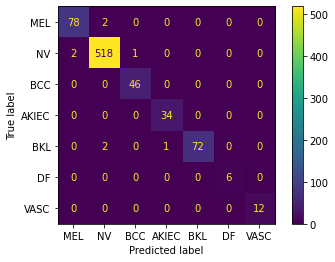

In [78]:
print('performance of model on male validation data:')
valdir = f'{ROOT_DIR}/skin/validation_male_female/male/'

val_transforms = transforms.Compose([
    transforms.Resize((224, 280)),
    torchvision.transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

val_dataset = datasets.ImageFolder(
    valdir, transform=val_transforms)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=64, shuffle=False,
    pin_memory=False, drop_last=False)

num_classes = 7

predlist = torch.zeros(0,dtype=torch.long, device='cpu')
lbllist = torch.zeros(0,dtype=torch.long, device='cpu')
predlistauc = torch.zeros(0,dtype=torch.long, device='cpu')

model.eval()

with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_loader):        
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])
        predlistauc = torch.cat([predlistauc,nn.functional.softmax(outputs, dim=1).cpu()])
predlist = predlist.numpy()
lbllist = lbllist.numpy()
predlistauc = predlistauc.numpy()

conf_mat=confusion_matrix(lbllist, predlist)

target_names = ['MEL','NV','BCC','AKIEC','BKL','DF','VASC',]

ConfusionMatrixDisplay(conf_mat, display_labels=target_names).plot(values_format="d")

print(classification_report(lbllist, predlist, target_names=target_names))

lbllist_one_hot = nn.functional.one_hot(torch.tensor([lbllist]), num_classes=num_classes)
every_auc = roc_auc_score(lbllist_one_hot.view([predlistauc.shape[0], predlistauc.shape[1]]), 
                                          predlistauc, multi_class='ovr', average=None)
for i, every in enumerate(target_names):
    print(f'AUC of class {every} = {every_auc[i]}')

## evaluate model on female validation data.

performance of model on female validation data:
              precision    recall  f1-score   support

         MEL       1.00      0.95      0.98        43
          NV       0.99      1.00      1.00       558
         BCC       1.00      0.95      0.97        20
       AKIEC       1.00      0.83      0.91        12
         BKL       0.94      0.97      0.96        68
          DF       1.00      1.00      1.00         9
        VASC       1.00      1.00      1.00         8

    accuracy                           0.99       718
   macro avg       0.99      0.96      0.97       718
weighted avg       0.99      0.99      0.99       718

AUC of class MEL = 0.9991386735572783
AUC of class NV = 0.9993615591397849
AUC of class BCC = 0.9999283667621777
AUC of class AKIEC = 0.9997639282341833
AUC of class BKL = 0.9996380090497737
AUC of class DF = 1.0
AUC of class VASC = 1.0


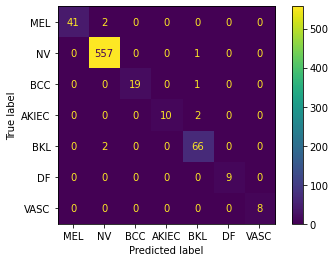

In [79]:
print('performance of model on female validation data:')
valdir = f'{ROOT_DIR}/skin/validation_male_female/female/'

val_transforms = transforms.Compose([
    transforms.Resize((224, 280)),
    torchvision.transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

val_dataset = datasets.ImageFolder(
    valdir, transform=val_transforms)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=64, shuffle=False,
    pin_memory=False, drop_last=False)

num_classes = 7

predlist = torch.zeros(0,dtype=torch.long, device='cpu')
lbllist = torch.zeros(0,dtype=torch.long, device='cpu')
predlistauc = torch.zeros(0,dtype=torch.long, device='cpu')

model.eval()

with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_loader):        
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])
        predlistauc = torch.cat([predlistauc,nn.functional.softmax(outputs, dim=1).cpu()])
predlist = predlist.numpy()
lbllist = lbllist.numpy()
predlistauc = predlistauc.numpy()

conf_mat=confusion_matrix(lbllist, predlist)

target_names = ['MEL','NV','BCC','AKIEC','BKL','DF','VASC',]

ConfusionMatrixDisplay(conf_mat, display_labels=target_names).plot(values_format="d")

print(classification_report(lbllist, predlist, target_names=target_names))

lbllist_one_hot = nn.functional.one_hot(torch.tensor([lbllist]), num_classes=num_classes)
every_auc = roc_auc_score(lbllist_one_hot.view([predlistauc.shape[0], predlistauc.shape[1]]), 
                                          predlistauc, multi_class='ovr', average=None)
for i, every in enumerate(target_names):
    print(f'AUC of class {every} = {every_auc[i]}')